In [1]:
# !pip install pythainlp
# !pip install stop_words

In [502]:
import pythainlp
from pythainlp import word_tokenize

from pythainlp.corpus import wordnet


In [503]:
from pythainlp.corpus import thai_stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words

In [504]:
from stop_words import get_stop_words

In [505]:
import nltk
nltk.download('words')
th_stop = tuple(thai_stopwords())
en_stop = tuple(get_stop_words('en'))
p_stemmer = PorterStemmer()

[nltk_data] Downloading package words to /Users/nat/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [506]:
import re
import string

def clean_msg(msg):
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    msg = re.sub(r'<.*?>','', msg)
    
    # ลบ hashtag
    msg = re.sub(r'#','',msg)
    msg = msg.replace('ชิมช็อปใช้เฟส', '')    
    msg = msg.replace('ชิมช็อปใช้', '')
    msg = msg.replace('ลทบ', 'ลงทะเบียน')    
    
    # ลบ เครื่องหมายคำพูด (punctuation)
    for c in string.punctuation:
        msg = re.sub(r'\{}'.format(c),'',msg)
    
    # ลบ separator เช่น \n \t
    msg = ' '.join(msg.split())
    
    return msg

In [507]:
def split_word(text):
    tokens = word_tokenize(text,engine='newmm')
    
#     # Remove stop words ภาษาไทย และภาษาอังกฤษ
    tokens = [i for i in tokens if not i in th_stop and not i in en_stop]
    
    # หารากศัพท์ภาษาไทย และภาษาอังกฤษ
    # English
    tokens = [p_stemmer.stem(i) for i in tokens]
    
    # Thai
    tokens_temp=[]
    for i in tokens:
        w_syn = wordnet.synsets(i)
        if (len(w_syn)>0) and (len(w_syn[0].lemma_names('tha'))>0):
            tokens_temp.append(w_syn[0].lemma_names('tha')[0])
        else:
            tokens_temp.append(i)
    
    tokens = tokens_temp
    
#     # ลบตัวเลข
    tokens = [i for i in tokens if not i.isnumeric()]
    
#     # ลบช่องว่าง
    tokens = [i for i in tokens if not ' ' in i]

    return tokens

In [508]:
split_word("สวัสดีจ้าแมวสุนัขหมา")

['สวัสดี', 'แมว', 'สุนัข', 'หมา']

In [509]:
!pwd

/Users/nat/0000_DataScienceJupyter/000A/notebooks


In [510]:
import pandas as pd

In [511]:
tweets = pd.read_csv('shop.csv',encoding="utf8", header=None)

In [517]:
tweets.head()

,0
0,ตื่นตี5:30มันวันหยุดกูกูกดเข้าระบบตั้งแต่5:55แ...
1,#ชิมช็อปใช้เฟส2 มึงมาประกาศรับลงทะเบียนให้ แล...
2,เข้าได้รอบเดียว คือทำได้ต่อยาว เช้านี้10คน หมด...
3,เต็มแล้วจ้าาา ตื่นมาทำไรตั้งแต่ตี 5 😂😂 #ชิมช็อ...
4,เก็บเงินค่าซื้อหวยแต่ละเดือนได้มากกว่าชิมช้อปใ...


In [518]:
tweets.describe()

,0
count,1228
unique,1226
top,เต็มละจ้า #ชิมช็อปใช้เฟส2
freq,2


In [519]:
# t=tweets[0]
data = []
clean_text = [clean_msg(str(txt)) for txt in tweets[0]]
for tweet in clean_text:
    data.append(split_word(str(tweet)))
    
# t
# print(type(t))
# for i in t:
#     print(i)

In [126]:
# clean_text

In [520]:
print(data[1])
# print(tweets.loc[0][0])

['ประกาศรับ', 'ลงทะเบียน', 'คนอื่น', 'ไม่ได้', 'ลูก', 'ดี', 'กาล', 'วิ่ง', 'นิ', 'นั่ง', 'ไถ', 'โทร', 'แล้วก็', 'ออกจาก', 'หน้า', 'เวป', 'ดิ']


In [521]:
# BOW

In [522]:
from sklearn.feature_extraction.text import CountVectorizer
tokens_list = data

In [523]:
tokens_list_j = [','.join(tkn) for tkn in tokens_list]
cvec = CountVectorizer(analyzer=lambda x:x.split(','))
c_feat = cvec.fit_transform(tokens_list_j)

In [524]:
# c_feat

<1228x2128 sparse matrix of type '<class 'numpy.int64'>'
	with 9523 stored elements in Compressed Sparse Row format>

In [528]:
# cvec.vocabulary_

In [529]:
# tokens_list_j

In [530]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(analyzer=lambda x:x.split(','),)
t_feat = tvec.fit_transform(tokens_list_j)

In [531]:
# t_feat.toarray()

In [532]:
# tvec.get_feature_names()

In [533]:
# t_feat[:,:5].todense()

In [534]:
len(tvec.idf_)

2128

In [535]:
len(tokens_list)

1228

In [536]:
#!pip install gensim

In [537]:
from gensim.models import Word2Vec

In [538]:
model = Word2Vec(tokens_list, min_count=1)
aa=model.wv.similar_by_word('แม่')
print(aa)

[('คน', 0.9896911382675171), ('ไม่ได้', 0.9886139631271362), ('กด', 0.9879720211029053), ('ทำ', 0.9875649213790894), ('รอ', 0.9863919019699097), ('\u200b', 0.9848146438598633), ('ลงทะเบียน', 0.9845171570777893), ('อี', 0.9828841686248779), ('นะคะ', 0.9820075035095215), ('คนอื่น', 0.9819350838661194)]


In [539]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(t_feat)


In [540]:
pd.DataFrame(pred_y).describe()

,0
count,1228.000000
mean,0.375407
std,0.819454
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.000000


In [582]:
summary = {}
for idx,tweet in enumerate(tokens_list):
    predicted_val = pred_y[idx]
    if predicted_val not in summary.keys():
        summary[predicted_val] = []
    summary[predicted_val] += [tweet]
    
    print("CLASS={} TWEET={}".format(predicted_val, ','.join(tweet)))

CLASS=0 TWEET=ตื่น,ตี,วันหยุด,กด,ระบบ,ทำ,แต่วัน,เฟส,เฟส,รอบ,เช้า,รอบ,เย็น,เวลานี้,เต็ม,ด้าย,พี่น้อง,ฝาก,เทียว,ถาม,หัว,ร้อน,เลือก,คน,เหรอ,วะ,ทำ,เลือก,ล่ะ,หัว,ร้อน,ว้อย,ย
CLASS=0 TWEET=ประกาศรับ,ลงทะเบียน,คนอื่น,ไม่ได้,ลูก,ดี,กาล,วิ่ง,นิ,นั่ง,ไถ,โทร,แล้วก็,ออกจาก,หน้า,เวป,ดิ
CLASS=0 TWEET=รอบ,ทำได้,เช้านี้,คน,ห่วง,สักที,ไอ,บ้า,😂
CLASS=3 TWEET=เต็ม,าา,ตื่น,ทำ,ตี,😂😂
CLASS=2 TWEET=เก็บเงิน,ค่า,ซื้อ,หวย,เดือน,ชิม,ช้อป
CLASS=0 TWEET=ว่ะ,งง
CLASS=3 TWEET=รอบ,เช้า,เต็ม,รอบ,เย็น,คิว,ว่าง,นะคะ,​
CLASS=1 TWEET=ระบบ,ขี้โกง,พวกเรา,รอ,คิว,คน,ลงทะเบียน,ไม่ต้อง,รอ,คิว,ในขณะที่,​คนรอ,รอ,ต่อไป
CLASS=0 TWEET=แนะนำ,เนต,บ้าน,เนต,โทร,พิชิต,อ่ะ,แน่,ร้าน,เนต,แรง,ร้าน,เนต,ชัว
CLASS=0 TWEET=ตอนเย็น,เจอกัน
CLASS=3 TWEET=เช้านี้,เต็ม,แสน,ไว
CLASS=0 TWEET=ท้อ,​
CLASS=3 TWEET=เช้า,ฝดใฝ,ฉุด,ฉุด,เต็ม
CLASS=0 TWEET=ข้อ,ความใน,โทร,ไม่สำเร็จ,พอดู,เมลล์,อะ,สำเร็จ,นึง,ไม่สำเร็จ,นึง,เมลล์,หนู,อี,น,ไห,นคะ
CLASS=0 TWEET=เสียเวลา,อิ,ห่า,ตี,ตี,เเปด,น.,ไม่ได้,แม่,ดุ,แน่
CLASS=0 TWEET=หวย,ใช้ไม่ได้,อ่า
CLASS=0 TWEET=น,สิทธิ์,เช้า

In [542]:
# summar

In [580]:
tweets

,0
0,ตื่นตี5:30มันวันหยุดกูกูกดเข้าระบบตั้งแต่5:55แ...
1,#ชิมช็อปใช้เฟส2 มึงมาประกาศรับลงทะเบียนให้ แล...
2,เข้าได้รอบเดียว คือทำได้ต่อยาว เช้านี้10คน หมด...
3,เต็มแล้วจ้าาา ตื่นมาทำไรตั้งแต่ตี 5 😂😂 #ชิมช็อ...
4,เก็บเงินค่าซื้อหวยแต่ละเดือนได้มากกว่าชิมช้อปใ...
5,ทำไมวันนี้มันง่ายจังว่ะ ได้มาแบบงงๆ #ชิมช็อปใช...
6,รอบเช้าเต็มแล้วรอบเย็นคิวว่างนะคะ​ #ชิมช็อปใช้...
7,เอาจริงๆนะ ระบบเรียกว่าค่อนข้างขี้โกงไปหน่อย เ...
8,แนะนำนะ ใช้เนตบ้าน เนตโทรศัพท์เอาชนะยากอ่ะ เอา...
9,ตอนเย็นเจอกัน!! #ชิมช็อปใช้เฟส2


In [581]:
q = pd.DataFrame.from_dict(summary, orient='index')

In [544]:
for i in range(n_clusters):
    print("class={}".format(i))
    print("--------------")    
    print(q.loc[i].describe())
    print("--------------")

class=0
--------------
count     970
unique    945
top        []
freq       13
Name: 0, dtype: object
--------------
class=1
--------------
count           120
unique          116
top       [รอ, คิว]
freq              3
Name: 1, dtype: object
--------------
class=2
--------------
count                  73
unique                 68
top       [ลงทะเบียน, บ.]
freq                    4
Name: 2, dtype: object
--------------
class=3
--------------
count         65
unique        58
top       [เต็ม]
freq           6
Name: 3, dtype: object
--------------


In [549]:
q.loc[1].describe()

count           120
unique          116
top       [รอ, คิว]
freq              3
Name: 1, dtype: object

In [550]:
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [551]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

# words = [reverse_dictionary[i] for i in range(1, num_points+1)]
# plot(two_d_embeddings, words)

In [552]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;

In [553]:
Z = model.wv.vectors

In [555]:
centers, clusters = clustering_on_wordvecs(Z, 20);

In [558]:
centers, clusters = clustering_on_wordvecs(Z, 4);

In [559]:
pd.DataFrame(clusters).describe()

,0
count,2127.000000
mean,0.538787
std,1.097022
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.000000


In [562]:
labels = model.wv.index2word

In [563]:
pred_y

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [565]:
xz

,0,1,2,3
row_1,3,2,1,0
row_2,a,b,c,d


In [566]:
# labels

In [567]:
import matplotlib.pyplot as plt # วาดรูป
from pythainlp.tokenize import word_tokenize # ตัดคำไทย
from wordcloud import WordCloud # สร้าง Wordcloud

In [583]:
def wordCloud(lst):
    wordcloud = WordCloud(font_path='THSarabunNew.ttf',
         background_color="white",
                      width=1600, # กว้าง
                      	height=900, # ยาว
                      	collocations=False,
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+"
                      ).generate(' '.join(lst))
    plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [584]:
flatten = lambda l: [item for sublist in l for item in sublist]
cls = {}

for i in range(n_clusters):
    s = q.loc[i]
    cls[i] = []
    for item in s:
        if item is not None:
            cls[i] += item


In [585]:
len(cls[1])

1081

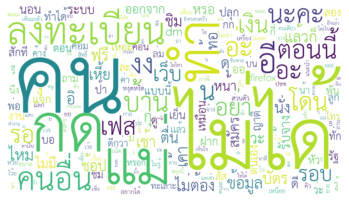

In [586]:
# class 1 ด่า
wordCloud(cls[0])


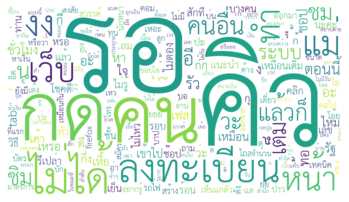

In [587]:
# class 2 รอ

wordCloud(cls[1])

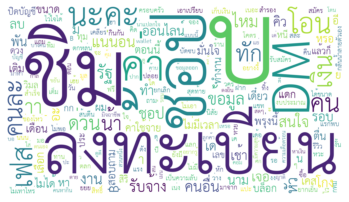

In [588]:
#class 3 ลงทะเบียน
wordCloud(cls[2])

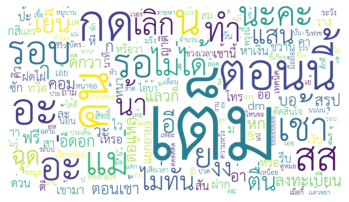

In [589]:
#class 4 เต็ม
wordCloud(cls[3])

In [590]:
# plot(pred_y[20:50], labels[20:50])

In [591]:
pred_y

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)